In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifier,Ridge
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from catboost import CatBoostClassifier,CatBoostRegressor
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier

In [2]:
X = pd.read_csv('data/X_train.csv',index_col='ROW_ID')
X_test_final = pd.read_csv('data/X_test.csv',index_col='ROW_ID')
y = pd.read_csv('data/y_train.csv',index_col='ROW_ID')
y_bin = (y > 0).astype(int) #binariser l outcome pour faire de la classification et pas regression
sample_submission = pd.read_csv('data/sample_submission.csv',index_col='ROW_ID')

In [3]:

RET_features = [f'RET_{i}' for i in range(1, 20)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1, 20)]
TURNOVER_features = ['AVG_DAILY_TURNOVER']

for i in [3, 5, 10, 15, 20]:
    X[f'AVERAGE_PERF_{i}'] = X[RET_features[:i]].mean(1)
    X[f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X.groupby('TS')[f'AVERAGE_PERF_{i}'].transform('mean')
    X_test_final[f'AVERAGE_PERF_{i}'] = X_test_final[RET_features[:i]].mean(1)
    X_test_final[f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_test_final.groupby('TS')[f'AVERAGE_PERF_{i}'].transform('mean')

features = RET_features + SIGNED_VOLUME_features + TURNOVER_features
features += [f'AVERAGE_PERF_{i}' for i in [3, 5, 10, 15, 20]]
features += [f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in [3, 5, 10, 15, 20]]

In [4]:
X["RET_VOLATILITY_20"] = X[RET_features].std(axis=1)
X_test_final["RET_VOLATILITY_20"] = X_test_final[RET_features].std(axis=1)

X["RET_MOMENTUM"] = X["RET_1"] - X[RET_features].mean(axis=1)
X_test_final["RET_MOMENTUM"] = X_test_final["RET_1"] - X_test_final[RET_features].mean(axis=1)

# Ratio perf/vol (Sharpe-like)
X["RET_SHARPE"] = X["RET_MOMENTUM"] / (X["RET_VOLATILITY_20"] + 1e-6)
X_test_final["RET_SHARPE"] = X_test_final["RET_MOMENTUM"] / (X_test_final["RET_VOLATILITY_20"] + 1e-6)

# Liquidity volatility
X["SIGNED_VOLUME_VOL"] = X[SIGNED_VOLUME_features].std(axis=1)
X_test_final["SIGNED_VOLUME_VOL"] = X_test_final[SIGNED_VOLUME_features].std(axis=1)

X["TS_num"] = X["TS"].str.extract("(\d+)").astype(int)
X_test_final["TS_num"] = X_test_final["TS"].str.extract("(\d+)").astype(int)
X["RET_TREND_5"] = X["RET_20"] - X["RET_15"]
X["VOL_TREND_5"] = X["SIGNED_VOLUME_20"] - X["SIGNED_VOLUME_15"]

# Décalage du dernier retour
X["RET_LAG1"] = X["RET_1"]
X["RET_DIFF1"] = X["RET_1"] - X["RET_2"]

# Skewness et kurtosis sur les 20 derniers jours
X["RET_SKEW_20"] = X[RET_features].skew(axis=1)
X["RET_KURT_20"] = X[RET_features].kurt(axis=1)

# Ratio volume/performance (liquidité relative)
X["VOL_PERF_RATIO"] = X[SIGNED_VOLUME_features].mean(axis=1) / (X[RET_features].std(axis=1) + 1e-6)

# Moyenne pondérée des performances récentes (momentum lissé)
weights = np.linspace(1, 2, 19)
X["RET_WEIGHTED_MOMENTUM"] = (X[RET_features].values * weights).sum(axis=1) / weights.sum()




<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/3058631560.py:15: SyntaxWarning: invalid escape sequence '\d'
  X["TS_num"] = X["TS"].str.extract("(\d+)").astype(int)
/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/3058631560.py:16: SyntaxWarning: invalid escape sequence '\d'
  X_test_final["TS_num"] = X_test_final["TS"].str.extract("(\d+)").astype(int)


In [5]:
unique_dates = np.sort(X['TS'].unique())
n = len(unique_dates)
train_dates = unique_dates[: int(0.8 * n)]   # 80% train
test_dates = unique_dates[int(0.8 * n):]     # 20% test

train_idx = X['TS'].isin(train_dates)
test_idx = X['TS'].isin(test_dates)

X_train, y_train_bin, y_train_cont = X.loc[train_idx, :], y_bin.loc[train_idx], y.loc[train_idx]
X_test, y_test_bin, y_test_cont = X.loc[test_idx, :], y_bin.loc[test_idx], y.loc[test_idx]


In [6]:
enc = TargetEncoder()
X_train["alloc_enc"] = enc.fit_transform(X_train["ALLOCATION"], y_train_bin)
X_test["alloc_enc"] = enc.transform(X_test["ALLOCATION"], y_test_bin)
X_train["ALLOC_TS_INTER"] = X_train["alloc_enc"] * X_train["TS_num"]
X_test["ALLOC_TS_INTER"] = X_test["alloc_enc"] * X_test["TS_num"]

/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/70527865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["alloc_enc"] = enc.fit_transform(X_train["ALLOCATION"], y_train_bin)
/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/70527865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["alloc_enc"] = enc.transform(X_test["ALLOCATION"], y_test_bin)
/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/70527865.py:4: SettingWithCopyWarning: 
A value 

In [7]:
features = (
    RET_features
    + SIGNED_VOLUME_features
    + TURNOVER_features
    + [f'AVERAGE_PERF_{i}' for i in [3, 5, 10, 15, 20]]
    + [f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in [3, 5, 10, 15, 20]]
    + ["RET_VOLATILITY_20", "RET_MOMENTUM", "RET_SHARPE", "SIGNED_VOLUME_VOL","VOL_TREND_5","RET_TREND_5"]
    + ["alloc_enc"]
    +["TS_num"]
    +["VOL_PERF_RATIO","RET_KURT_20","RET_SKEW_20","RET_DIFF1","RET_LAG1"]
)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features].fillna(0))
X_test_scaled = scaler.transform(X_test[features].fillna(0))

In [9]:
results_classif = {}

name, model="RidgeClassifier",RidgeClassifier(alpha=1e-2, fit_intercept=False)
model.fit(X_train_scaled, y_train_bin)
y_pred = model.predict(X_test_scaled)


# Évaluation
acc = accuracy_score(y_test_bin, y_pred)
results_classif[name] = acc
print(f"✅ Test Accuracy ({name}): {acc:.4f}")

# Importance des features
print("\n🔍 Top 10 feature importances:")

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_.ravel())  # abs pour Ridge

importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)
top_half = importance_df.iloc[:importance_df.shape[0] // 2]["feature"].tolist()
best_ridge = top_half



✅ Test Accuracy (RidgeClassifier): 0.5282

🔍 Top 10 feature importances:


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
scaler = StandardScaler()
features=best_ridge
X_train_scaled = scaler.fit_transform(X_train[features].fillna(0))
X_test_scaled = scaler.transform(X_test[features].fillna(0))

In [11]:
models_classif = {
    "RidgeClassifier": RidgeClassifier(alpha=1e-2, fit_intercept=False),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    '''''
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss',
    ),
    '''''
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=0
    )
}

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training RidgeClassifier (classification)...
✅ Test Accuracy (RidgeClassifier): 0.5303

🔍 Top 10 feature importances:
                       feature  importance
0                    alloc_enc    0.051710
1                   RET_SHARPE    0.021700
2                       RET_15    0.019044
26             AVERAGE_PERF_15    0.018260
3   ALLOCATIONS_AVERAGE_PERF_5    0.013896
4                  RET_TREND_5    0.013874
20                       RET_1    0.011743
21                    RET_LAG1    0.011743
5                        RET_6    0.011678
9             SIGNED_VOLUME_19    0.011506


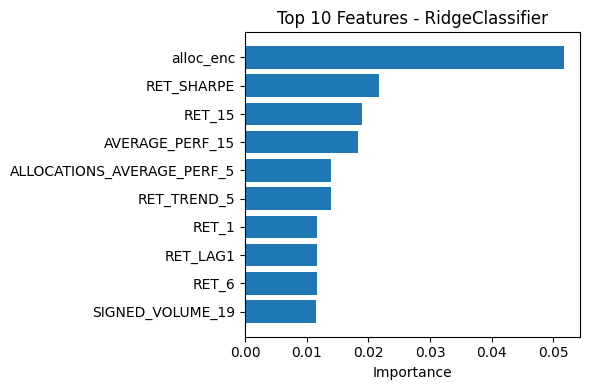


Training RandomForest (classification)...
✅ Test Accuracy (RandomForest): 0.5254

🔍 Top 10 feature importances:
                        feature  importance
0                     alloc_enc    0.092068
21                     RET_LAG1    0.053926
20                        RET_1    0.051312
3    ALLOCATIONS_AVERAGE_PERF_5    0.048201
19  ALLOCATIONS_AVERAGE_PERF_20    0.046072
7    ALLOCATIONS_AVERAGE_PERF_3    0.044712
1                    RET_SHARPE    0.042045
11  ALLOCATIONS_AVERAGE_PERF_15    0.041981
8   ALLOCATIONS_AVERAGE_PERF_10    0.038877
22              AVERAGE_PERF_20    0.032352


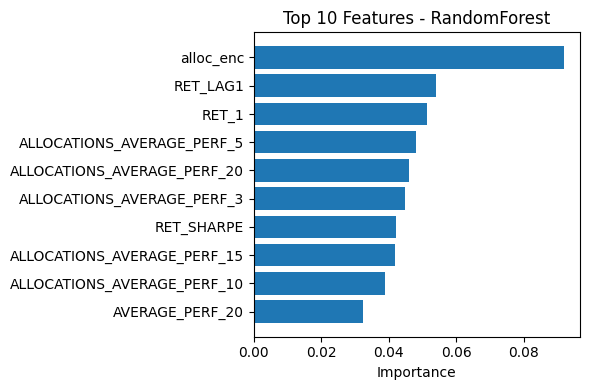


Training ''
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss',
    ),
    CatBoost (classification)...
✅ Test Accuracy (''
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label

/var/folders/tp/p2fdv61s7979qs0rlp6mh9qw0000gn/T/ipykernel_58247/1309119317.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


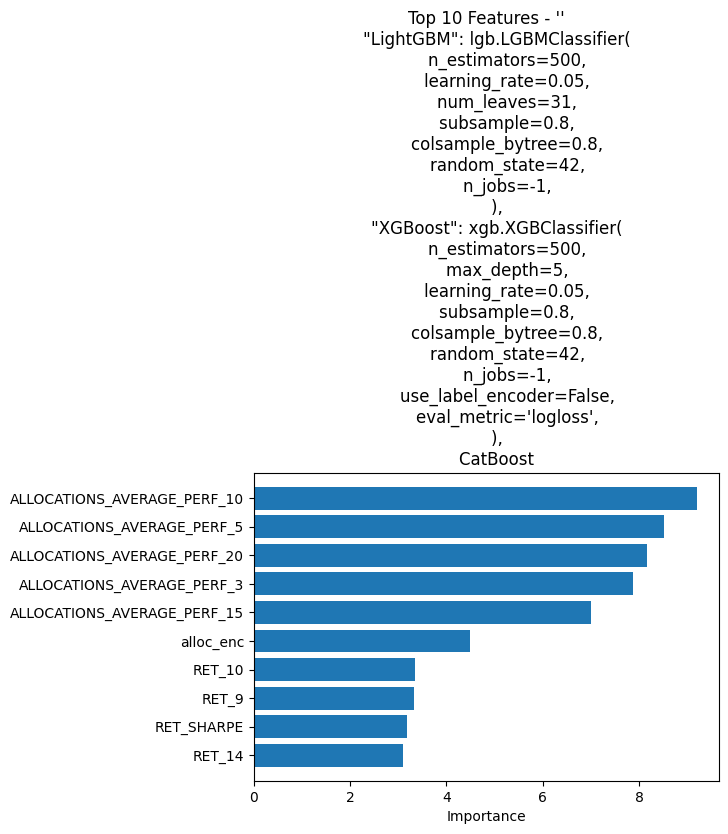

In [12]:
results_classif = {}

for name, model in models_classif.items():
    print(f"\n{'='*30}\nTraining {name} (classification)...\n{'='*30}")
    
    # Entraînement
    if "Ridge" in name:
        model.fit(X_train_scaled, y_train_bin)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train[features].fillna(0), y_train_bin.values.ravel())
        y_pred = model.predict(X_test[features].fillna(0))
    
    # Évaluation
    acc = accuracy_score(y_test_bin, y_pred)
    results_classif[name] = acc
    print(f"✅ Test Accuracy ({name}): {acc:.4f}")
    
    # Importance des features
    print("\n🔍 Top 10 feature importances:")
    try:
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_.ravel())  # abs pour Ridge
        else:
            raise AttributeError("No feature importance attribute found.")
        
        importance_df = pd.DataFrame({
            "feature": features,
            "importance": importances
        }).sort_values("importance", ascending=False)
        top_half = importance_df.iloc[:importance_df.shape[0] // 2]["feature"].tolist()

        if "Ridge" in name:
            best_ridge = top_half
        elif "Random" in name:
            best_rf = top_half
        print(importance_df.head(10))
        
        # Plot
        plt.figure(figsize=(6, 4))
        plt.barh(importance_df["feature"].head(10)[::-1],
                 importance_df["importance"].head(10)[::-1])
        plt.title(f"Top 10 Features - {name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"⚠️ Could not compute feature importances for {name}: {e}")



In [13]:
# Arrondir à 0.01
results_classif_rounded = {k: round(v, 3) for k, v in results_classif.items()}

print("\nClassification results (arrondi à 0.01):")
print(results_classif_rounded)



Classification results (arrondi à 0.01):
{'RidgeClassifier': 0.53, 'RandomForest': 0.525, '\'\'\n    "LightGBM": lgb.LGBMClassifier(\n        n_estimators=500,\n        learning_rate=0.05,\n        num_leaves=31,\n        subsample=0.8,\n        colsample_bytree=0.8,\n        random_state=42,\n        n_jobs=-1,\n    ),\n    "XGBoost": xgb.XGBClassifier(\n        n_estimators=500,\n        max_depth=5,\n        learning_rate=0.05,\n        subsample=0.8,\n        colsample_bytree=0.8,\n        random_state=42,\n        n_jobs=-1,\n        use_label_encoder=False,\n        eval_metric=\'logloss\',\n    ),\n    CatBoost': 0.521}
